# ADA - Project Milestone P2
The jupyter notebook presenting our initial results.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [35]:
# general helpers
def ratio_to_percentage(ratio):
    """
    
    :param ratio: a number between 0 and 1
    :return: the corresponding percentage with two decimal places
    """
    return round(ratio * 100, 2)

In [36]:
df_ba_users = pd.read_csv("data/BeerAdvocate/users.csv")
df_rb_users = pd.read_csv("data/RateBeer/users.csv")

exp_threshold = 15

df_ba_experienced_users = df_ba_users[df_ba_users["nbr_ratings"] > exp_threshold]
df_rb_experienced_users = df_rb_users[df_rb_users["nbr_ratings"] > exp_threshold]

In [37]:
num_users_ba = len(df_ba_users)
num_exp_users_ba = len(df_ba_experienced_users)
num_users_rb = len(df_rb_users)
num_exp_users_rb = len(df_rb_experienced_users)

perc_ba = 100 - ratio_to_percentage(num_exp_users_ba / num_users_ba)
print("By filtering the datasets, we lost " + str(perc_ba) + "% (" + str(num_users_ba - num_exp_users_ba) + "/" + str(num_users_ba) + ")" + " of the beer advocate dataset")

perc_rb = 100 - ratio_to_percentage(num_exp_users_rb / num_users_rb)
print("By filtering the datasets, we lost " + str(perc_rb) + "% (" + str(num_users_rb - num_exp_users_rb) + "/" + str(num_users_rb) + ")" + " of the rate beer dataset")

perc_both = round((num_users_ba / (num_users_ba + num_users_rb)) * perc_ba + (num_users_rb  / (num_users_rb + num_users_ba)) * perc_rb, 2)
print("Taking both datasets in account we lost " + str(perc_both) + "% (" + str(num_users_ba + num_users_rb - num_exp_users_ba - num_exp_users_rb) + "/" + str(num_exp_users_ba + num_users_rb) + ")" + " of the users")

By filtering the datasets, we lost 74.84% (115025/153704) of the beer advocate dataset
By filtering the datasets, we lost 80.22% (56295/70174) of the rate beer dataset
Taking both datasets in account we lost 76.53% (171320/108853) of the users


# Expereince measured by used words analysis

In [38]:
# a list containing words that only a true expert would say
exp_words_general = ["Lacing", "Ester", "Diacetyl", "Phenol", "Dry Hop", "DMS", "Oxidation", "catty", "resinous", "astringent", "Effervescent", "Tannic", "Brettanomyces", "lactic", "autolysis", "Krausen"]

exp_words_general2 = ["Ester", "Diacetyl", "DMS", "resinous", "astringent", "Effervescent", "Tannic", "Brettanomyces", "lactic", "autolysis", "Krausen"]

exp_words_general3 = ["Ester", "Diacetyl", "DMS", "resinous", "astringent", "Effervescent"]


exp_words = ["Ester"]

In [39]:
df_rb_ratings = pd.read_csv("data/RateBeer/ratings/ratings.csv")

In [40]:
regex_pattern = "|".join(exp_words)
df_rb_ratings_exp = df_rb_ratings[df_rb_ratings["text"].str.contains(regex_pattern, case=False, na=False)]

In [41]:
exp_user_ids = df_rb_ratings_exp["user_id"].unique()
print("Total number of users: ", len(df_rb_ratings["user_id"].unique()))
print("Number of experienced users: ", len(exp_user_ids))

Total number of users:  70121
Number of experienced users:  5937


In [42]:
df_rb_ratings_wo_text = pd.read_csv("data/RateBeer/ratings/ratings.csv", usecols=lambda col: col != "text")

In [43]:
df_rb_ratings_of_exp = df_rb_ratings_wo_text[df_rb_ratings_wo_text["user_id"].isin(exp_user_ids)]

In [44]:
print(len(df_rb_ratings_of_exp))

5775760


In [45]:
print(len(df_rb_ratings_wo_text))

7122074


That makes no sense. I can't imagine that the experienced user group wrote almost all the reviews and wrote 604.7 reviews on average...

In [46]:
print("Average number of reviews per user: ", df_rb_ratings["user_id"].value_counts().mean())

Average number of reviews per user:  101.56834614452161


In [47]:
print("Average number of reviews per exp. user: ", df_rb_ratings_of_exp["user_id"].value_counts().mean())

Average number of reviews per exp. user:  972.8415024423109


Anyway, let's go on a little

In [48]:
print("Avg. grade of experienced user: ", df_rb_ratings_of_exp["rating"].mean())

Avg. grade of experienced user:  3.2831560002493183


In [49]:
df_rb_ratings_of_unexp = df_rb_ratings_wo_text[~df_rb_ratings_wo_text["user_id"].isin(exp_user_ids)]

In [50]:
print("Avg. grade of unexperienced user: ", df_rb_ratings_of_unexp["rating"].mean())

Avg. grade of unexperienced user:  3.2957841929891525


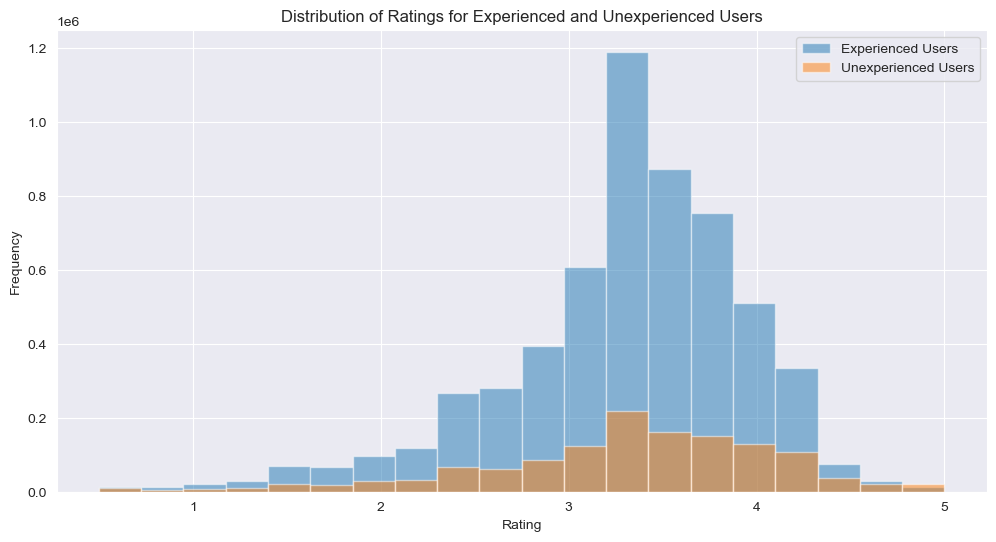

In [51]:
import matplotlib.pyplot as plt

# plotting the distribution
plt.figure(figsize=(12, 6))
plt.hist(df_rb_ratings_of_exp["rating"], bins=20, alpha=0.5, label="Experienced Users")
plt.hist(df_rb_ratings_of_unexp["rating"], bins=20, alpha=0.5, label="Unexperienced Users")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Ratings for Experienced and Unexperienced Users")
plt.show()

In [52]:
print("Variance of ratings for experienced users: ", df_rb_ratings_of_exp["rating"].var())
print("Variance of ratings for unexperienced users: ", df_rb_ratings_of_unexp["rating"].var())


Variance of ratings for experienced users:  0.4290705186172317
Variance of ratings for unexperienced users:  0.6520552887168728


Let's try another way to define an experienced user. An experienced user is now a user who has used all the words from the exp_word list once. It doesn't have to be in the same rating, just at some point.

In [53]:
# users that used all words from the exp_word list
user_ids_with_all_words = set()

for user_id in tqdm(df_rb_ratings["user_id"].unique(), desc="Scanning users"):
    # concatting all the rating texts this user wrote
    user_reviews = df_rb_ratings[df_rb_ratings["user_id"] == user_id]["text"].str.cat(sep=" ").lower()

    # check whether he used every word at least once
    if all(word.lower() in user_reviews for word in exp_words_general3):
        user_ids_with_all_words.add(user_id)

df_rb_ratings_all_exp = df_rb_ratings[df_rb_ratings["user_id"].isin(user_ids_with_all_words)]

print("Number of users who used all words:", len(user_ids_with_all_words))

Scanning users: 100%|██████████| 70121/70121 [07:25<00:00, 157.38it/s]


Number of users who used all words: 274


In [54]:
df_rb_ratings_all_exp_avg = df_rb_ratings_all_exp["rating"].mean()

print("Avg rating of exp. users: ", df_rb_ratings_all_exp_avg)

print("Number of reviews by these users: ", len(df_rb_ratings_all_exp))

print("What's going on with this user with the id 195...")
print(df_rb_users[df_rb_users["user_id"] == 195])

Avg rating of exp. users:  3.272183717463417
Number of reviews by these users:  914317
What's going on with this user with the id 195...
     nbr_ratings  user_id user_name       joined location
170        16396      195     Oakes  961754400.0   Canada


In [55]:
df_rb_ratings_all_unexp = df_rb_ratings[~df_rb_ratings["user_id"].isin(user_ids_with_all_words)]

print("Avg rating of unexp. users: ", df_rb_ratings_all_unexp["rating"].mean())

Avg rating of unexp. users:  3.2875108191251656


In [56]:
df_rb_ratings_all_exp.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1445594400,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours l...
13,Régab,19445,Sobraga,3198,Pale Lager,4.5,1438509600,nimbleprop,38859,2,5,2,5,8,2.2,"16oz can pours a clear gold with some cloudy, ..."
31,Régab,19445,Sobraga,3198,Pale Lager,4.5,1215511200,lgklotet,30812,2,1,2,1,5,1.1,"Bottle, thx Omhper. All my notes say for this ..."
35,Régab,19445,Sobraga,3198,Pale Lager,4.5,1209117600,omhper,2778,1,2,2,2,6,1.3,"Bottled. Pale golden, very brief head. Vegeta..."
38,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1429178400,ciaranc,151109,3,7,2,8,17,3.7,"Bottle, gift from Aaron. Black, big head, lots..."


# Now we do exactly the same but with the Beer Advocate Dataset

In [57]:
df_ba_ratings = pd.read_csv("data/BeerAdvocate/ratings/BA_ratings.csv")

df_ba_ratings_exp = df_ba_ratings[df_ba_ratings["text"].str.contains(regex_pattern, case=False, na=False)]
exp_user_ids_ba = df_ba_ratings_exp["user_id"].unique()
print("Total number of users: ", len(df_ba_ratings["user_id"].unique()))
print("Number of experienced users: ", len(exp_user_ids_ba))


Total number of users:  70121
Number of experienced users:  5937


In [58]:
df_ba_ratings_wo_text = pd.read_csv("data/BeerAdvocate/ratings/BA_ratings.csv", usecols=lambda col: col != "text")
df_ba_ratings_of_exp = df_ba_ratings_wo_text[df_ba_ratings_wo_text["user_id"].isin(exp_user_ids_ba)]
print(len(df_ba_ratings_of_exp))
print(len(df_ba_ratings_wo_text))

3086517
8393032


In [59]:
print("Average number of reviews per user: ", df_ba_ratings["user_id"].value_counts().mean())
print("Average number of reviews per exp. user: ", df_ba_ratings_of_exp["user_id"].value_counts().mean())

print("Avg. grade of experienced user: ", df_ba_ratings_of_exp["rating"].mean())
df_ba_ratings_of_unexp = df_ba_ratings_wo_text[~df_ba_ratings_wo_text["user_id"].isin(exp_user_ids_ba)]
print("Avg. grade of unexperienced user: ", df_ba_ratings_of_unexp["rating"].mean())

Average number of reviews per user:  54.60516317076979
Average number of reviews per exp. user:  375.4430117990512
Avg. grade of experienced user:  3.831609464648988
Avg. grade of unexperienced user:  3.9115159290042523


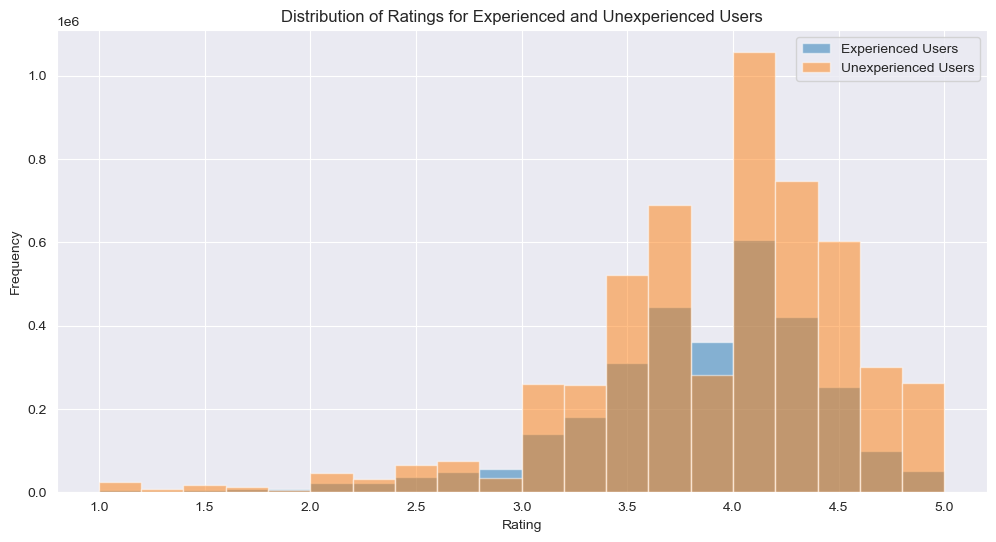

Variance of ratings for experienced users:  0.3269148978824913
Variance of ratings for unexperienced users:  0.41648620295613276


In [60]:
import matplotlib.pyplot as plt

# plotting the distribution
plt.figure(figsize=(12, 6))
plt.hist(df_ba_ratings_of_exp["rating"], bins=20, alpha=0.5, label="Experienced Users")
plt.hist(df_ba_ratings_of_unexp["rating"], bins=20, alpha=0.5, label="Unexperienced Users")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Ratings for Experienced and Unexperienced Users")
plt.show()
print("Variance of ratings for experienced users: ", df_ba_ratings_of_exp["rating"].var())
print("Variance of ratings for unexperienced users: ", df_ba_ratings_of_unexp["rating"].var())

In [62]:
# short test whether the stuff I'm doing actually makes sense / that I didn't make an error
a = set(df_ba_ratings_of_exp["user_id"]).intersection(set(df_ba_ratings_of_unexp["user_id"]))

if not a:
    print("Yes, no intersect.")

Yes, no intersect.


okay good.

In [61]:
# users that used all words from the exp_word list
user_ids_with_all_words_ba = set()

for user_id in tqdm(df_ba_ratings["user_id"].unique(), desc="Scanning users"):
    # concatting all the rating texts this user wrote
    user_reviews = df_ba_ratings[df_ba_ratings["user_id"] == user_id]["text"].str.cat(sep=" ").lower()

    # check whether he used every word at least once
    if all(word.lower() in user_reviews for word in exp_words_general3):
        user_ids_with_all_words_ba.add(user_id)

df_ba_ratings_all_exp = df_ba_ratings[df_ba_ratings["user_id"].isin(user_ids_with_all_words_ba)]

print("Number of users who used all words:", len(user_ids_with_all_words_ba))
df_ba_ratings_all_exp_avg = df_ba_ratings_all_exp["rating"].mean()

print("Avg rating of exp. users: ", df_ba_ratings_all_exp_avg)
print("Number of reviews by these users: ", len(df_ba_ratings_all_exp))
df_ba_ratings_all_unexp = df_ba_ratings[~df_ba_ratings["user_id"].isin(user_ids_with_all_words_ba)]
print("Avg rating of unexp. users: ", df_ba_ratings_all_unexp["rating"].mean())

Scanning users:   0%|          | 378/153704 [02:16<15:22:26,  2.77it/s]


KeyboardInterrupt: 

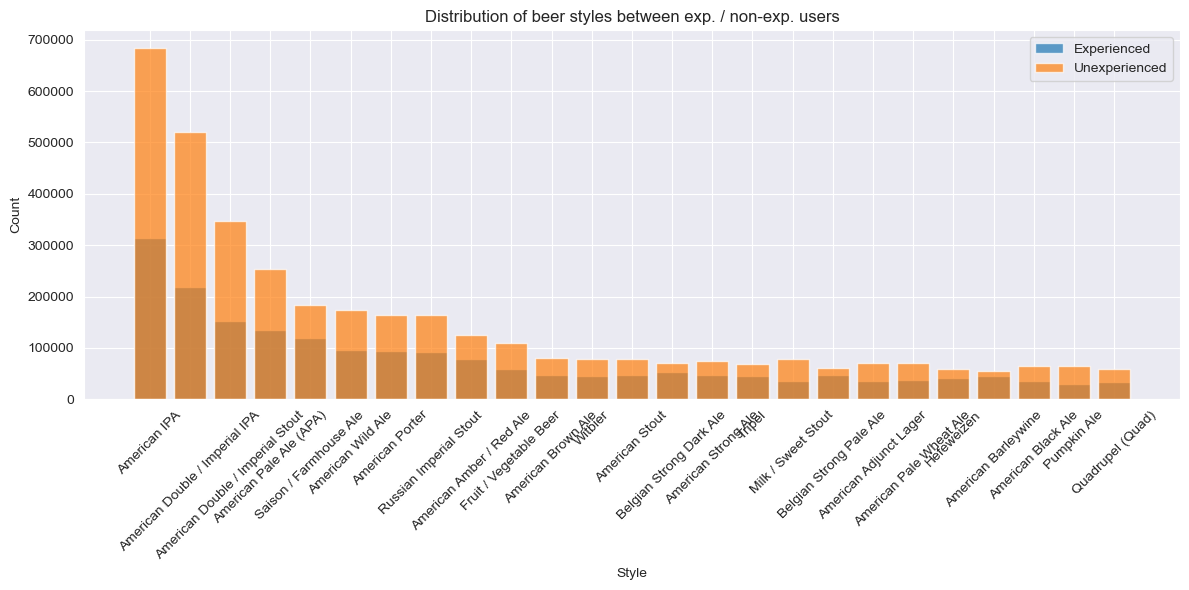

In [65]:
# show distribution of beer styles being rated between experts and novices
style_counts_exp = df_ba_ratings_of_exp['style'].value_counts()
style_counts_unexp = df_ba_ratings_of_unexp['style'].value_counts()

# 25 most rated styles
most_rated = (style_counts_exp + style_counts_unexp).nlargest(25).index

style_counts_exp = style_counts_exp[most_rated]
style_counts_unexp = style_counts_unexp[most_rated]

# plotting
plt.figure(figsize=(12, 6))
plt.bar(style_counts_exp.index, style_counts_exp.values, alpha=0.7, label='Experienced')
plt.bar(style_counts_unexp.index, style_counts_unexp.values, alpha=0.7, label='Unexperienced')

# Plot-Details hinzufügen
plt.xlabel('Style')
plt.ylabel('Count')
plt.title('Distribution of beer styles between exp. / non-exp. users')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()